# Előkészületek

## Szükséges könyvtárak importálása


In [18]:
%reset -f
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## Adatok beolvasása




Modellek összehasonlítása:
   Fokszám        R²         AIC
0        1  0.000000  387.062930
1        2  0.062344  385.844343
2        3  0.902997  274.412442
3        4  0.921054  266.113215

Negyedfokú polinom illesztése:
                            OLS Regression Results                            
Dep. Variable:                  Érték   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     178.9
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.30e-25
Time:                        21:41:11   Log-Likelihood:                -129.06
No. Observations:                  50   AIC:                             266.1
Df Residuals:                      46   BIC:                             273.8
Df Model:                           3                                         
Covariance Type:            nonrobust                           

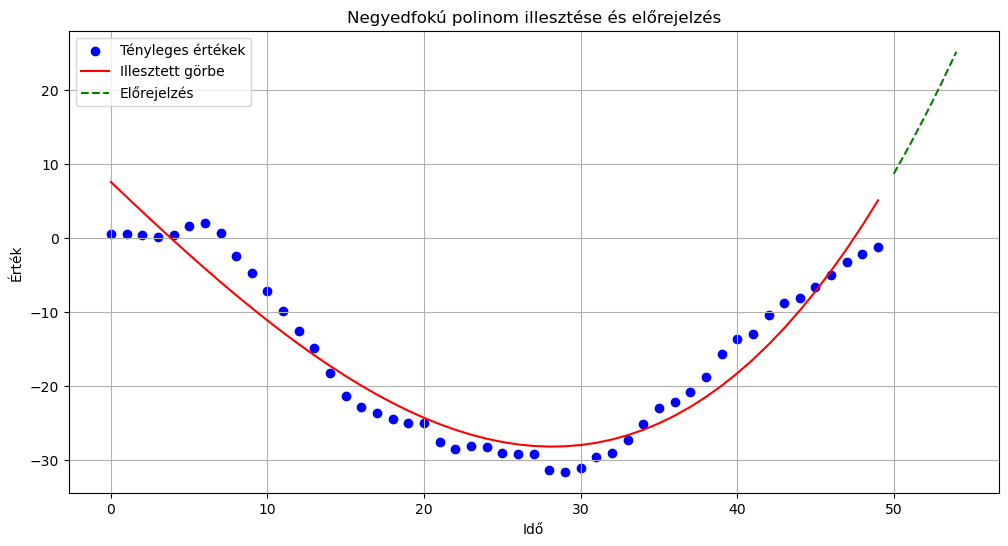

In [28]:
# Oszlopok definiálása
cols = ['Idő', 'Érték']

# Adatok beolvasása string-ként
with open('data/bead3.csv', 'r', encoding='latin-1') as file:
    lines = file.readlines()

# Az első sor elhagyása (mivel az az oszlopokat tartalmazza)
# Az értékek átalakítása soronként listává
data = [list(map(float, line.strip().strip('"').split(','))) for line in lines[1:]]

# DataFrame létrehozása
df = pd.DataFrame(data, columns=cols)

# Polinom fokszámának meghatározásához több modellt illesztünk és összehasonlítjuk
max_degree = 4  # maximum 4-edfokú polinomig megyünk

# Modellek összehasonlítása
results = []
for degree in range(1, max_degree + 1):
    # Polinom feature-ök létrehozása
    X = np.vander(df.index, degree + 1)
    
    # Modell illesztése
    model = sm.OLS(df['Érték'], sm.add_constant(X[:, 1:])).fit()
    
    # R² számítása
    r2 = r2_score(df['Érték'], model.fittedvalues)
    
    results.append({
        'Fokszám': degree,
        'R²': r2,
        'AIC': model.aic
    })

# Eredmények kiíratása
results_df = pd.DataFrame(results)
print("\nModellek összehasonlítása:")
print(results_df)

# Negyedfokú polinom illesztése
X = np.vander(df.index, 5)
model = sm.OLS(df['Érték'], sm.add_constant(X[:, 1:])).fit()

# Eredmények kiíratása
print("\nNegyedfokú polinom illesztése:")
print(model.summary())

# Reziduálisok vizsgálata
residuals = model.resid

# Reziduálisok alapstatisztikái
print("\nReziduálisok vizsgálata:")
print(f"Átlag: {np.mean(residuals):.6f}")
print(f"Szórás: {np.std(residuals):.6f}")

# Normalitás teszt
shapiro_stat, shapiro_p = sm.stats.diagnostic.normal_ad(residuals)
print(f"\nAnderson-Darling teszt p-érték: {shapiro_p:.6f}")

# Homoszkedaszticitás vizsgálata
breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(residuals, model.model.exog)
print(f"\nBreusch-Pagan teszt p-érték: {breusch_pagan_test[1]:.6f}")

# Előrejelzés a következő 5 időpontra
future_points = np.arange(len(df), len(df) + 5)
X_future = np.vander(future_points, 5)
predictions = model.predict(sm.add_constant(X_future[:, 1:]))

print("\nElőrejelzések:")
for i, pred in enumerate(predictions, 1):
    print(f"{len(df) + i}. időpont: {pred:.2f}")

# Ábrázolás
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Érték'], color='blue', label='Tényleges értékek')
plt.plot(df.index, model.fittedvalues, color='red', label='Illesztett görbe')
plt.plot(future_points, predictions, color='green', linestyle='--', label='Előrejelzés')
plt.xlabel('Idő')
plt.ylabel('Érték')
plt.title('Negyedfokú polinom illesztése és előrejelzés')
plt.legend()
plt.grid(True)
plt.show()